In [1]:
from bd2dst3pi.definitions import years, magnets
from bd2dst3pi.locations import loc
from copy import deepcopy
import pandas as pd

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, save_dataframe
from plot.tool import save_file
import plot.histogram as h
import BDT.BDT as bt

Welcome to JupyROOT 6.22/02


#  `adaboost_without_P_with_cut_deltaM_highB0M`
#  `gradient_without_P_with_cut_deltaM_highB0M`
- Samples:
    - background sample = high `B0_M` `common_M` sample: `5355. < B0_M < 5570`
    
- For all the samples, `143. < Delta_M < 148.`
- Sample weight balancing (in `BDT.py`)
- Use `AdaboostClassifier` or `XGBClassifier`

In [2]:
low_bkg = 5355.
high_bkg = 5570.

## Training variables

In [3]:
variables = []

# for particle in ['B0']:
#     variables.append(f"{particle}_M")

#for particle in ['B0', 'Dst', 'tau']:
for particle in ['B0', 'Dst', 'tau_pion0', 'tau_pion1', 'tau_pion2']:
    #variables.append(f"{particle}_P")
    variables.append(f"{particle}_PT")

# for particle in ['B0', 'tau', 'D0']:
#     variables.append(f"{particle}_ENDVERTEX_CHI2")

for particle in ['B0', 'tau']:
    variables.append(f"{particle}_ENDVERTEX_CHI2")
    
variables.append('B0_OWNPV_CHI2')
variables.append('tau_FDCHI2_OWNPV')
variables.append('B0_FDCHI2_OWNPV')
variables.append('B0_DIRA_OWNPV')
variables.append('Dst_IPCHI2_OWNPV')    

for particle in ['tau_pion0', 'tau_pion1', 'tau_pion2']:
    variables.append(f'{particle}_TRACK_MatchCHI2')
    variables.append(f"{particle}_TRACK_GhostProb")  
    
for particle in ['tau_pion0', 'tau_pion1', 'tau_pion2', 'Dst_pion', 'D0_kaon', 'D0_pion']:
    variables.append(f"{particle}_TRACK_CHI2NDOF")
    

    
add_variables = ['B0_M', 'tau_M', 'Dst_M', 'D0_M']

## Load data

In [4]:
low_bkg = 5355
high_bkg = 5550

In [32]:
#name_BDT = 'adaboost_bkgHighB0M_1'
name_BDT = 'gradient_bkgHighB0M'


### Full datasets

In [6]:
df = {}
print("retrieve MC")
df['MC'] = load_data(years,magnets, type_data = 'MC',vars = add_variables + variables) # already cut on DeltaM
print("retrieve common data")
df['common'] = load_data(years, magnets, type_data = 'common', vars = add_variables + variables, cut_DeltaM=True)
add_variables.append("Delta_M")

retrieve MC
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root
retrieve common data
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


### Remove some variables

The variables `Dst_M`, `D0_M` and `DeltaM`, created by the cut on `DeltaM`, are not trained with and need to be removed from the datasample.

### Splitting of the `common` data

We randomly split the `common` data into two samples of same size

In [7]:
df['common1'] = df['common'].sample(frac=0.5, random_state=100)
df['common2'] = df['common'].drop(df['common1'].index,0).sample(frac=1.)

df['MC1'] = df['MC'].sample(frac=0.5, random_state=100)
df['MC2'] = df['MC'].drop(df['MC1'].index,0).sample(frac=1.)

Some checks that they have the same size and are randomly separated

In [8]:
print(len(df['common1']), len(df['common2']))

255086 255087


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_data_1_data_2
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_data_1_data_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Proportion of candidates / (4 MeV/$c^2$)'>)

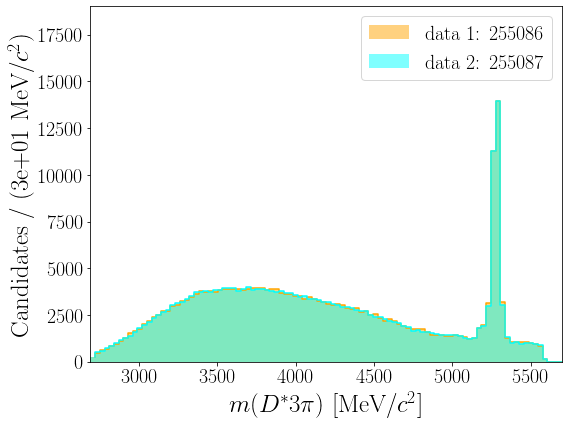

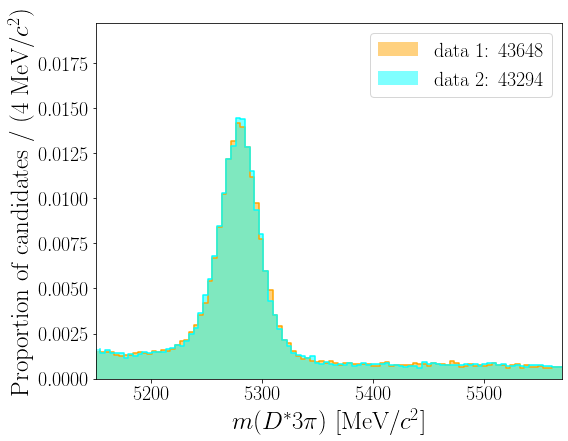

In [9]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']},'B0_M',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)
low=5150
high=5570
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']},'B0_M',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'],
                    low=low, high=high)

### Background samples

In [10]:
df['bkg1'] = df['common1'].query(f'B0_M > {low_bkg} and B0_M <{high_bkg}')
df['bkg2'] = df['common2'].query(f'B0_M > {low_bkg} and B0_M <{high_bkg}')
print('bgk1: ', len(df['bkg1']), 'events')
print('bgk2: ', len(df['bkg2']), 'events')

bgk1:  6629 events
bgk2:  6526 events


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_bkg_1_bkg_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>)

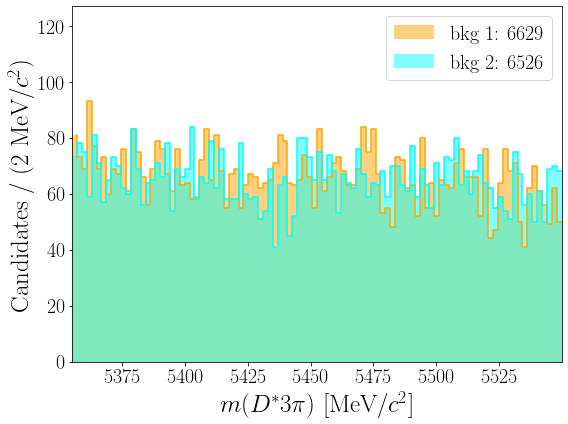

In [11]:
h.plot_hist_particle({'bkg 1': df['bkg1'], 'bkg 2':df['bkg2']},'B0_M',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)

In [12]:
for data in 'bkg1', 'bkg2', 'MC1', 'MC2':
    for add_var in add_variables+['index']:
        try:
            df[data] = df[data].drop(add_var, 1)
        except KeyError:
            pass

In [13]:
for data in 'common1', 'common2': # with training variables
    df[data+'_t'] = deepcopy(df[data])
    for add_var in add_variables+['index']:
        df[data+'_t'] = df[data+'_t'].drop(add_var, 1)

In [14]:
print(df['bkg1'].columns)
print(df['bkg2'].columns)
print(df['MC1'].columns)
print(df['MC2'].columns)

Index(['B0_PT', 'Dst_PT', 'tau_pion0_PT', 'tau_pion1_PT', 'tau_pion2_PT',
       'B0_ENDVERTEX_CHI2', 'tau_ENDVERTEX_CHI2', 'B0_OWNPV_CHI2',
       'tau_FDCHI2_OWNPV', 'B0_FDCHI2_OWNPV', 'B0_DIRA_OWNPV',
       'Dst_IPCHI2_OWNPV', 'tau_pion0_TRACK_MatchCHI2',
       'tau_pion0_TRACK_GhostProb', 'tau_pion1_TRACK_MatchCHI2',
       'tau_pion1_TRACK_GhostProb', 'tau_pion2_TRACK_MatchCHI2',
       'tau_pion2_TRACK_GhostProb', 'tau_pion0_TRACK_CHI2NDOF',
       'tau_pion1_TRACK_CHI2NDOF', 'tau_pion2_TRACK_CHI2NDOF',
       'Dst_pion_TRACK_CHI2NDOF', 'D0_kaon_TRACK_CHI2NDOF',
       'D0_pion_TRACK_CHI2NDOF'],
      dtype='object')
Index(['B0_PT', 'Dst_PT', 'tau_pion0_PT', 'tau_pion1_PT', 'tau_pion2_PT',
       'B0_ENDVERTEX_CHI2', 'tau_ENDVERTEX_CHI2', 'B0_OWNPV_CHI2',
       'tau_FDCHI2_OWNPV', 'B0_FDCHI2_OWNPV', 'B0_DIRA_OWNPV',
       'Dst_IPCHI2_OWNPV', 'tau_pion0_TRACK_MatchCHI2',
       'tau_pion0_TRACK_GhostProb', 'tau_pion1_TRACK_MatchCHI2',
       'tau_pion1_TRACK_GhostProb', 'tau_p

## Analysis before training

### Concatenation

In [15]:
X1, y1, df1 = bt.concatenate(df['MC1'], df['bkg1'])
X2, y2, df2 = bt.concatenate(df['MC2'], df['bkg2'])

### 1D histograms

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M1/1D_hist_gradient_bkgHighB0M1


(<Figure size 2880x1800 with 28 Axes>,
 array([[<AxesSubplot:xlabel='$p_T$($D^{*}3\\pi$) [MeV/c]', ylabel='Candidates / (7e+02 MeV/c)'>,
         <AxesSubplot:xlabel='$p_T$($D^*$) [MeV/c]', ylabel='Candidates / (6e+02 MeV/c)'>,
         <AxesSubplot:xlabel='$p_T$($\\pi_0$) [MeV/c]', ylabel='Candidates / (2e+02 MeV/c)'>,
         <AxesSubplot:xlabel='$p_T$($\\pi_1$) [MeV/c]', ylabel='Candidates / (3e+02 MeV/c)'>,
         <AxesSubplot:xlabel='$p_T$($\\pi_2$) [MeV/c]', ylabel='Candidates / (4e+02 MeV/c)'>,
         <AxesSubplot:xlabel='ENDVERTEX\\_CHI2($D^{*}3\\pi$)', ylabel='Candidates / (9e+01)'>,
         <AxesSubplot:xlabel='ENDVERTEX\\_CHI2($3\\pi$)', ylabel='Candidates / (0.1)'>],
        [<AxesSubplot:xlabel='OWNPV\\_CHI2($D^{*}3\\pi$)', ylabel='Candidates / (1)'>,
         <AxesSubplot:xlabel='FDCHI2\\_OWNPV($3\\pi$)', ylabel='Candidates / (9e+03)'>,
         <AxesSubplot:xlabel='FDCHI2\\_OWNPV($D^{*}3\\pi$)', ylabel='Candidates / (3e+03)'>,
         <AxesSubplot:xlabel='DIRA\\_O

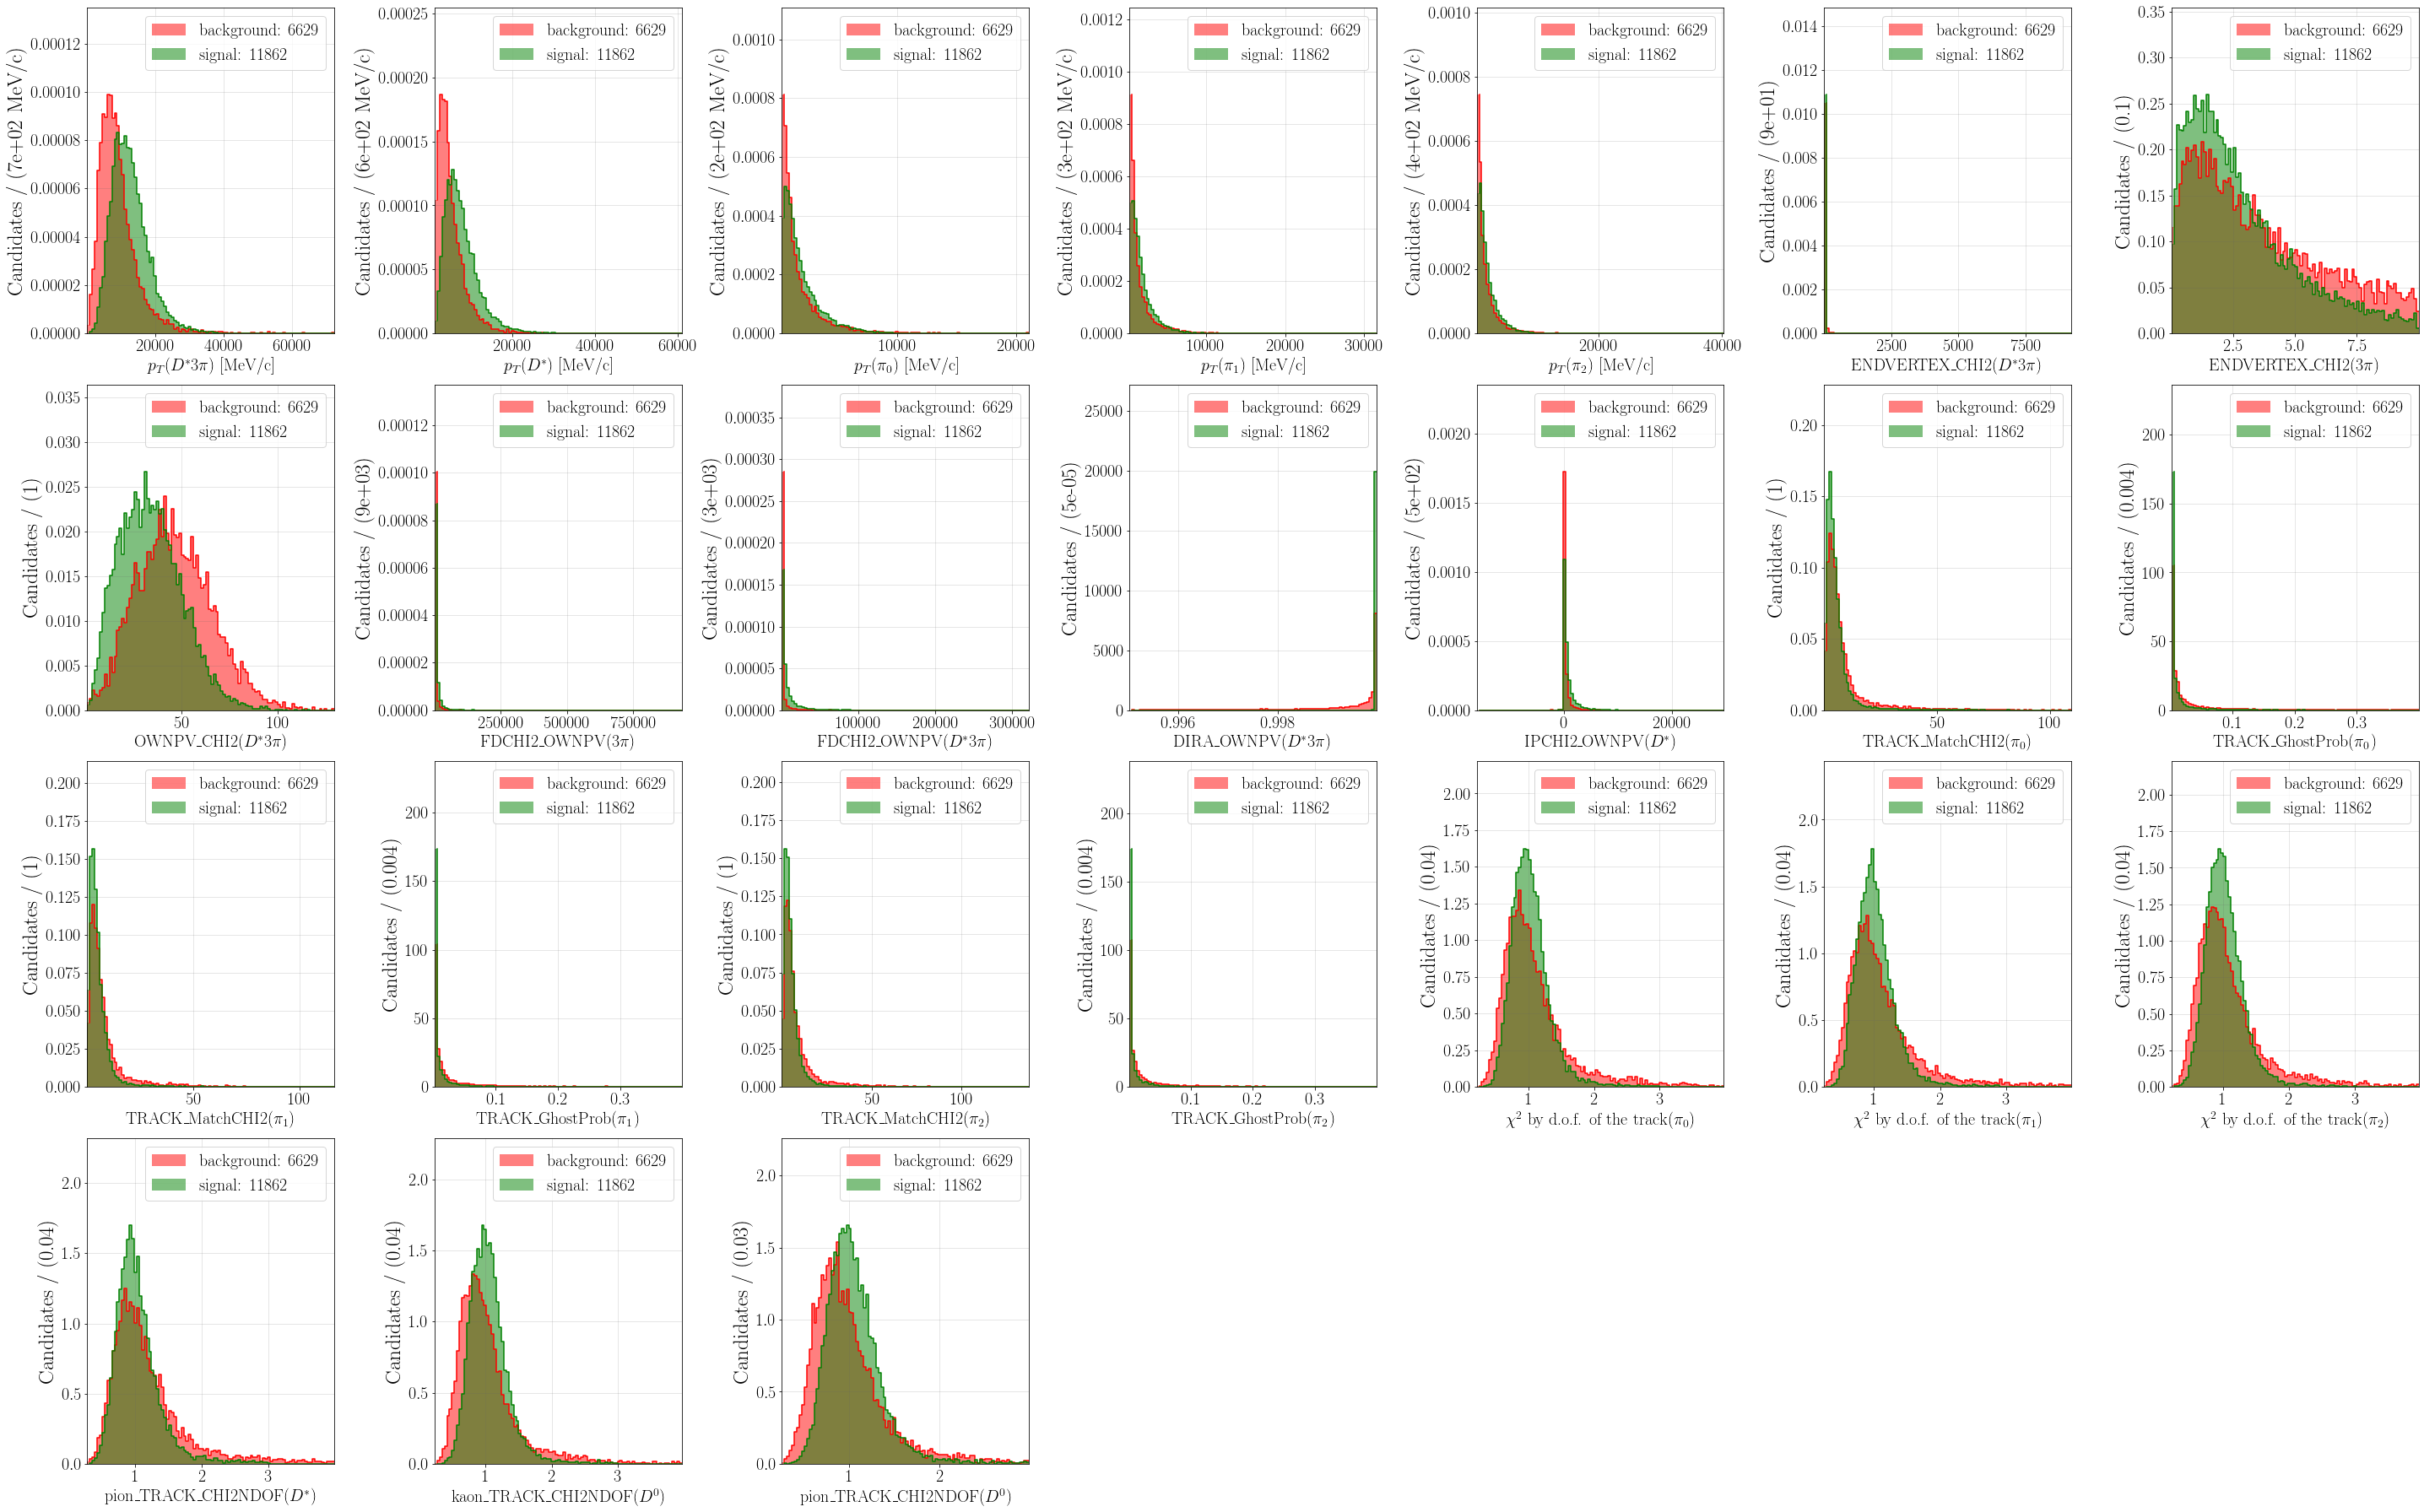

In [19]:
bt.signal_background(df1[df1.y<0.5], df1[df1.y>0.5],
                  column=variables,
#                   range_column=[
#                       [0,40000],
#                       [0,30000],
#                       [0,10000],
#                       [0,1e4],
#                       [0,1e4],
#                       [0,100],
#                       [0,15],
#                       None,None,None,None
#                   ],
                  n_bins=100, figsize = (40,25), name_file = name_BDT+'1', name_folder = name_BDT+'1')
# bt.signal_background(df2[df2.y<0.5], df2[df2.y>0.5],
#                   column=variables,
# #                   range_column=[
# #                       [0,40000],
# #                       [0,30000],
# #                       [0,20000],
# #                       [0,20000],
# #                       [0,100],
# #                       [0,100],
# #                       [0,15],
# #                       None,None,None,None
# #                   ],
#                   n_bins=100, figsize = (40,25), name_file = name_BDT+'2', name_folder = name_BDT+'2')

### Correlation matrix

In [16]:
bg1,sig1 = bt.bg_sig(y1)
bg2,sig2 = bt.bg_sig(y2)

Background
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M1/corr_matrix_gradient_bkgHighB0M_background1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M2/corr_matrix_gradient_bkgHighB0M_background2
Signal
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M1/corr_matrix_gradient_bkgHighB0M_signal1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M2/corr_matrix_gradient_bkgHighB0M_signal2


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlations'}>)

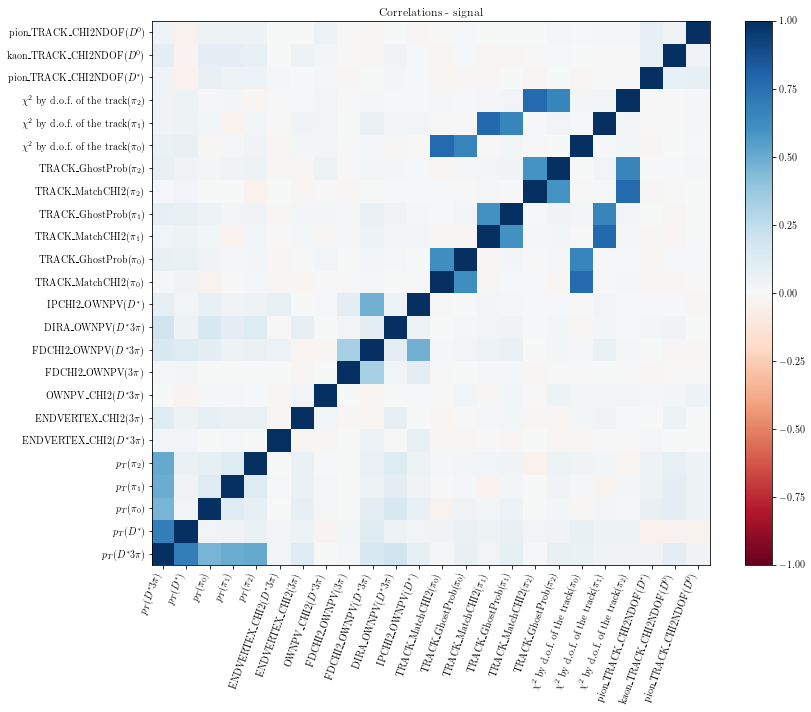

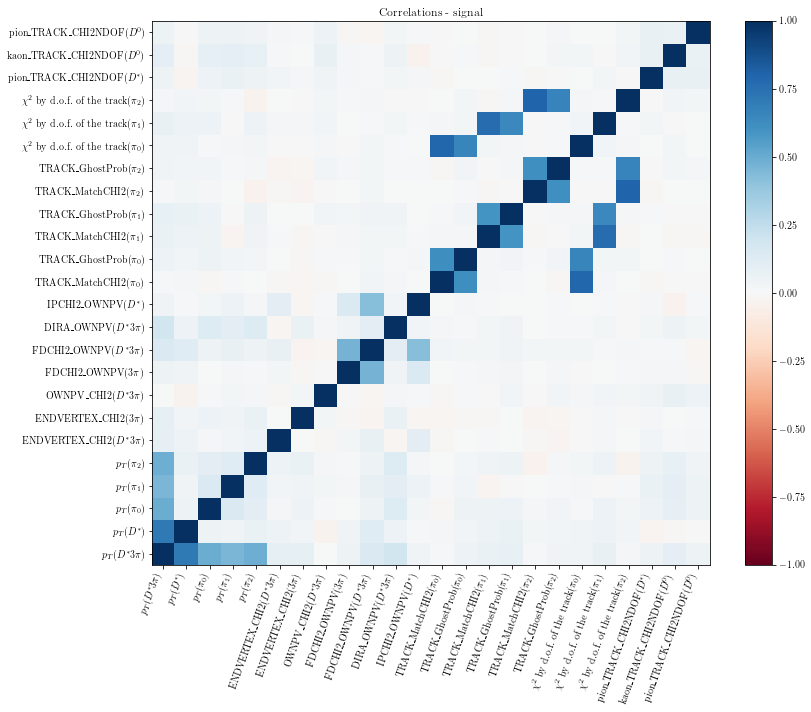

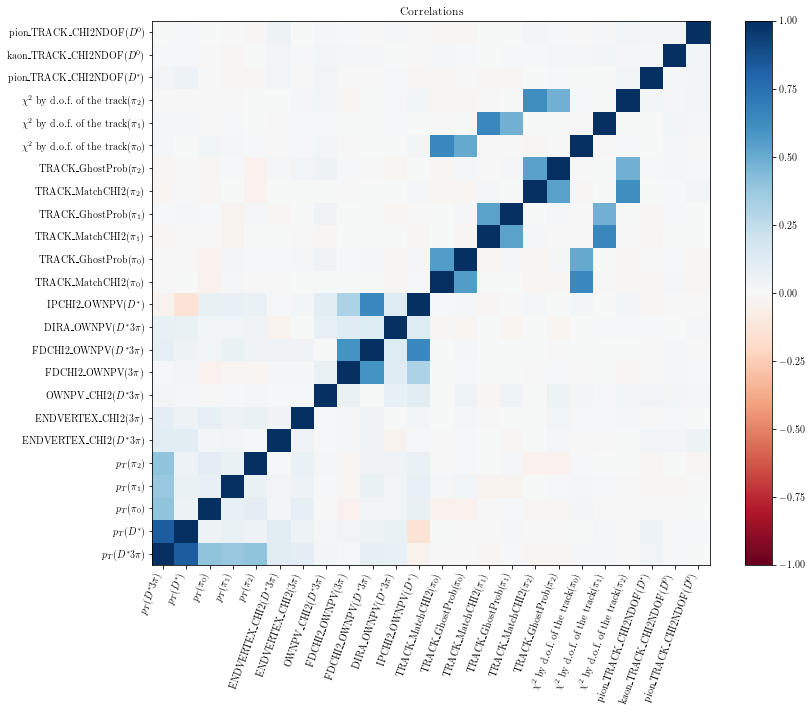

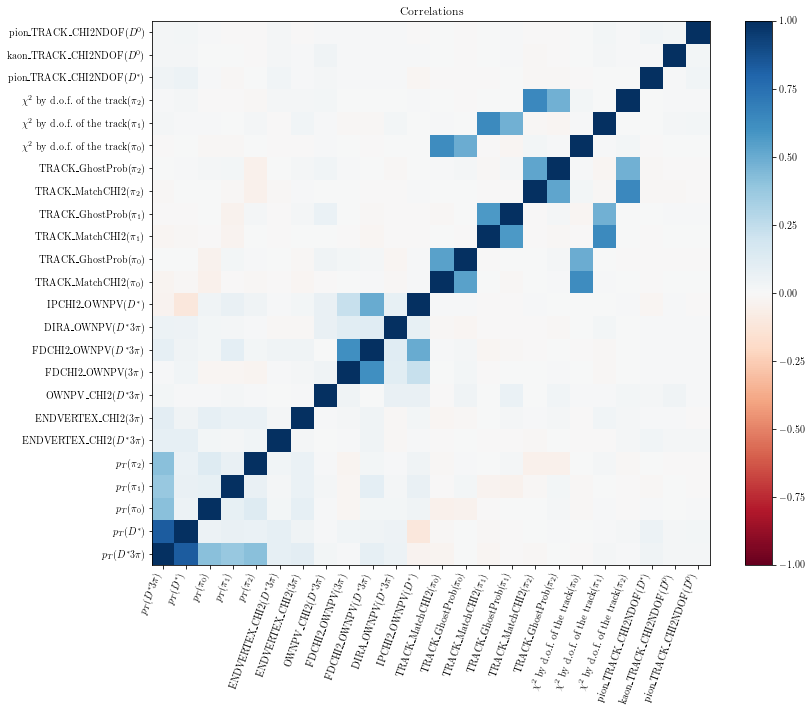

In [21]:
print("Background")
bt.correlations(df1[bg1].drop('y', 1), title = 'signal', name_file= name_BDT+'_background1', name_folder = name_BDT+'1') # Drop the column(->1) 'y'
bt.correlations(df2[bg2].drop('y', 1), title = 'signal', name_file= name_BDT+'_background2', name_folder = name_BDT+'2') # Drop the column(->1) 'y'

print("Signal")
bt.correlations(df1[sig1].drop('y', 1),name_file= name_BDT+'_signal1', name_folder = name_BDT+'1')
bt.correlations(df2[sig2].drop('y', 1),name_file= name_BDT+'_signal2', name_folder = name_BDT+'2')

## Training

In [50]:
X_train1, y_train1, X_test1, y_test1, bdt1 = bt.BDT(X1, y1, classifier = 'gradientboosting', n_estimators=500)

hyperparameters:
n_estimators: 500
learning_rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.2900           14.71s
         2           1.2114           14.71s
         3           1.1465           14.72s
         4           1.0925           14.68s
         5           1.0471           14.65s
         6           1.0089           14.62s
         7           0.9765           14.58s
         8           0.9488           14.54s
         9           0.9241           14.51s
        10           0.9021           14.48s
        20           0.7540           14.05s
        30           0.6787           13.73s
        40           0.6241           13.42s
        50           0.5835           13.12s
        60           0.5511           12.82s
        70           0.5235           12.53s
        80           0.5019           12.23s
        90           0.4833           11.94s
       100           0.4650           11.64s
       200           0.3657            8.71s


In [51]:
X_train2, y_train2, X_test2, y_test2, bdt2 = bt.BDT(X2, y2, classifier='gradientboosting', n_estimators=500)

hyperparameters:
n_estimators: 500
learning_rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.2854           14.48s
         2           1.2030           14.53s
         3           1.1350           14.53s
         4           1.0783           14.52s
         5           1.0307           14.48s
         6           0.9905           14.44s
         7           0.9564           14.41s
         8           0.9282           14.38s
         9           0.9008           14.35s
        10           0.8773           14.32s
        20           0.7201           13.93s
        30           0.6438           13.67s
        40           0.5927           13.41s
        50           0.5524           13.15s
        60           0.5221           12.88s
        70           0.4972           12.58s
        80           0.4748           12.26s
        90           0.4566           11.94s
       100           0.4393           11.65s
       200           0.3462            8.70s


## Testing

### Report

In [52]:
bt.classification_report_print(X_test1, y_test1, bdt1,name_BDT+'1')
bt.classification_report_print(X_test2, y_test2, bdt2,name_BDT+'2')

              precision    recall  f1-score   support

  background       0.93      0.92      0.92      3300
      signal       0.95      0.96      0.96      5946

    accuracy                           0.95      9246
   macro avg       0.94      0.94      0.94      9246
weighted avg       0.95      0.95      0.95      9246

Area under ROC curve: 0.9856
              precision    recall  f1-score   support

  background       0.94      0.92      0.93      3281
      signal       0.95      0.97      0.96      5913

    accuracy                           0.95      9194
   macro avg       0.95      0.94      0.94      9194
weighted avg       0.95      0.95      0.95      9194

Area under ROC curve: 0.9853


### Roc curve

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M_lessvars1/ROC_gradient_bkgHighB0M_lessvars1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M_lessvars2/ROC_gradient_bkgHighB0M_lessvars2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>)

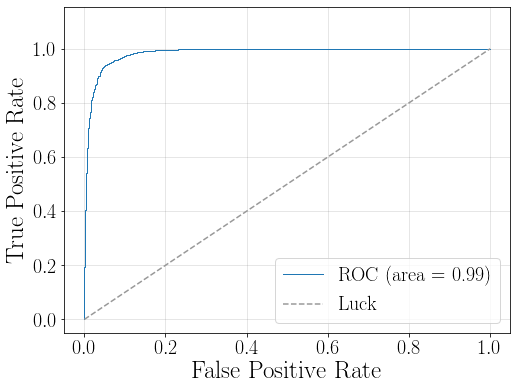

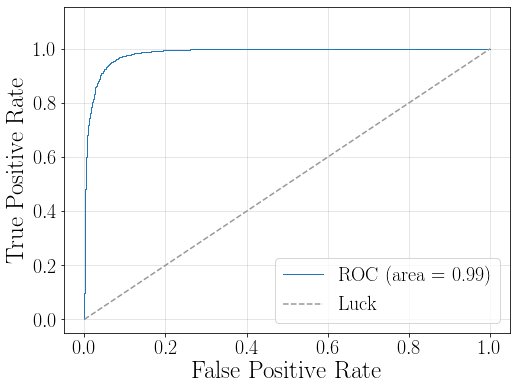

In [53]:
bt.plot_roc(X_test1, y_test1, bdt1, name_BDT+'1', name_folder = name_BDT+'1')
bt.plot_roc(X_test2, y_test2, bdt2, name_BDT+'2', name_folder = name_BDT+'2')

### Overtraining check

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M_lessvars1/overtraining_gradient_bkgHighB0M_lessvars1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient_bkgHighB0M_lessvars2/overtraining_gradient_bkgHighB0M_lessvars2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT output', ylabel='Arbitrary units'>)

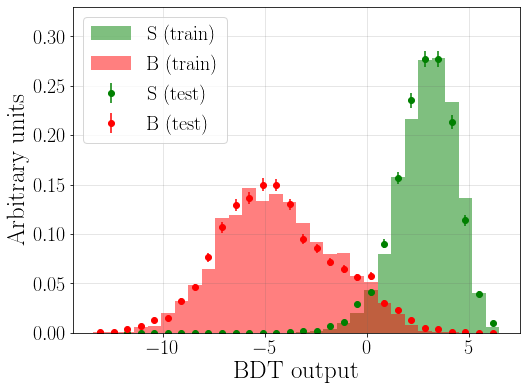

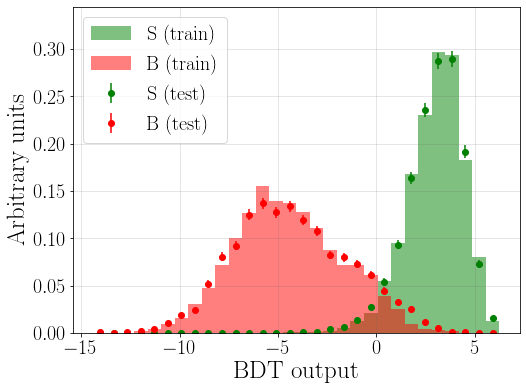

In [54]:
bt.compare_train_test(bdt1, X_train1, y_train1, X_test1, y_test1, name_BDT = name_BDT+'1', name_folder = name_BDT+'1')
bt.compare_train_test(bdt2, X_train2, y_train2, X_test2, y_test2, name_BDT = name_BDT+'2', name_folder = name_BDT+'2')

### Apply to the data

In [22]:
df['common1']['BDT'] = bdt2.decision_function(df['common1_t'])
df['common2']['BDT'] = bdt1.decision_function(df['common2_t'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_1_data_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Proportion of candidates / (0.2)'>)

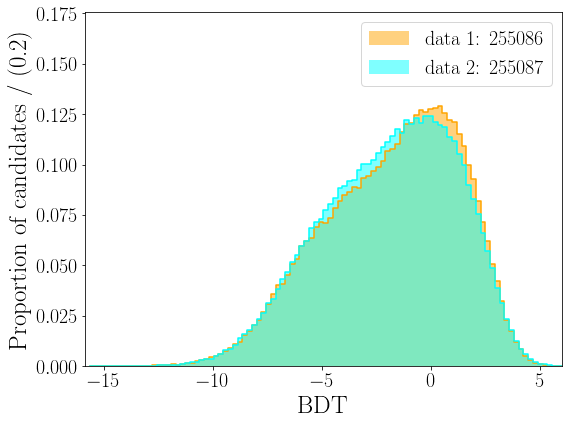

In [23]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']},'BDT',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'])

In [24]:
df['common_withBDT'] = pd.concat([df['common1'],df['common2']])
len(df['common_withBDT']) == len(df['common1']) + len(df['common2'])

True

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.2)'>)

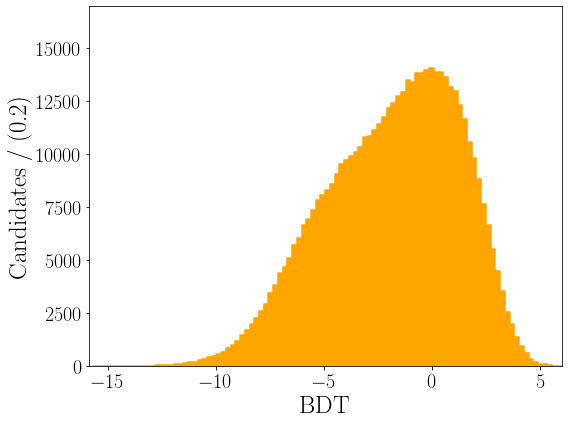

In [25]:
h.plot_hist_particle({'data': df['common_withBDT']},'BDT',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient_bkgHighB0M/BDT_cut_on_B0_M
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient_bkgHighB0M/BDT_cut_on_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

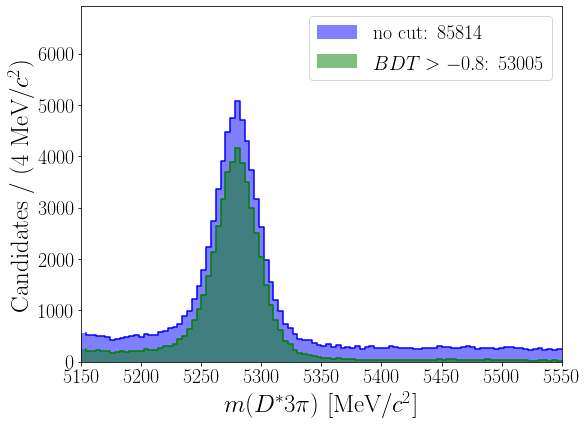

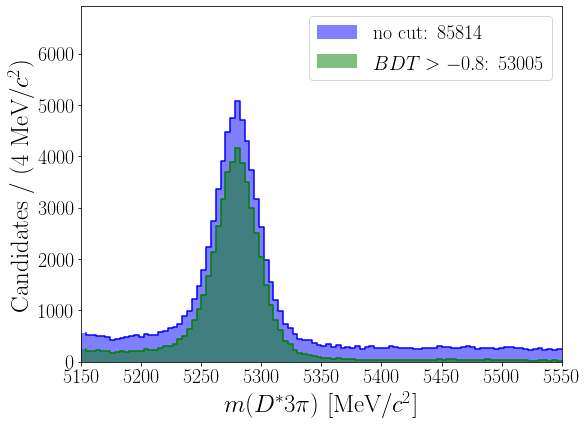

In [26]:
low = 5150.
high = 5550.

h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>-0.8$':df['common_withBDT'].query('BDT>-0.8')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)
h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>-0.8$':df['common_withBDT'].query('BDT>-0.8')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient_bkgHighB0M/BDT_cut_on_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

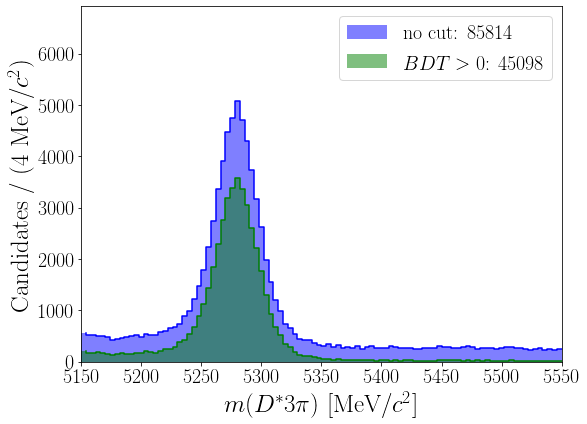

In [27]:
low = 5150.
high = 5550.

h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>0$':df['common_withBDT'].query('BDT>0')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient_bkgHighB0M/BDTvsB0_M


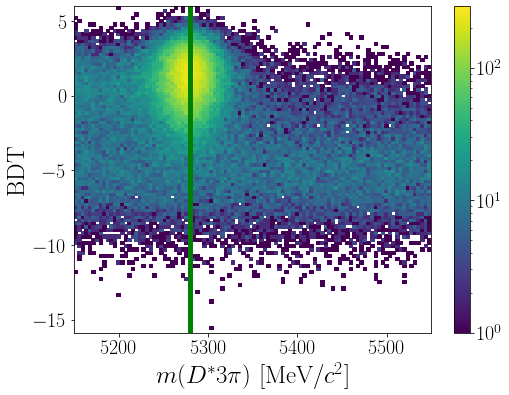

In [28]:
fig, ax = h.plot_hist2d_particle(df['common_withBDT'],['B0_M','BDT'], low=[low,None],high=[high,None],
            name_folder = name_BDT, log_scale = True, save_fig=False)
ax.axvline(x=5279.53, color='green', linewidth=5.)
save_file(fig, "BDTvsB0_M",name_BDT)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient_bkgHighB0M_lessvars/BDT_cut_on_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

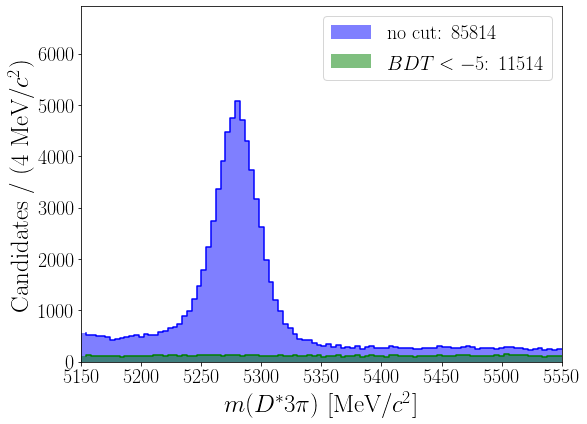

In [35]:
h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT<-5$':df['common_withBDT'].query('BDT<-5')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient_bkgHighB0M/BDT_cut_on_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (3e+01 MeV/$c^2$)'>)

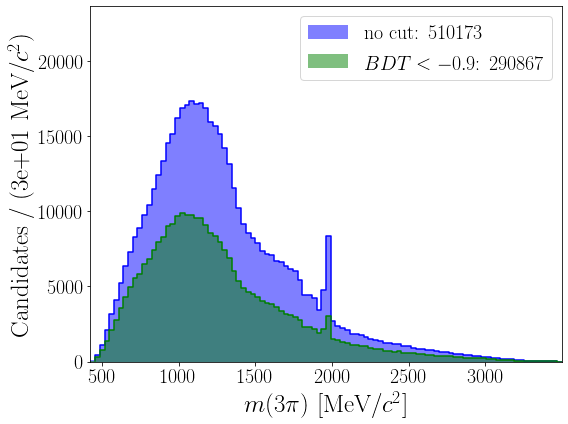

In [30]:
h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT<-0.9$':df['common_withBDT'].query('BDT<-0.9')},
          'tau_M', n_bins = 100, mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

In [31]:
save_dataframe(df['common_withBDT'], f'common_{name_BDT}', 'DecayTree', name_folder = 'common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_gradient_bkgHighB0M.root
